In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

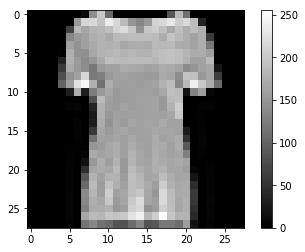

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

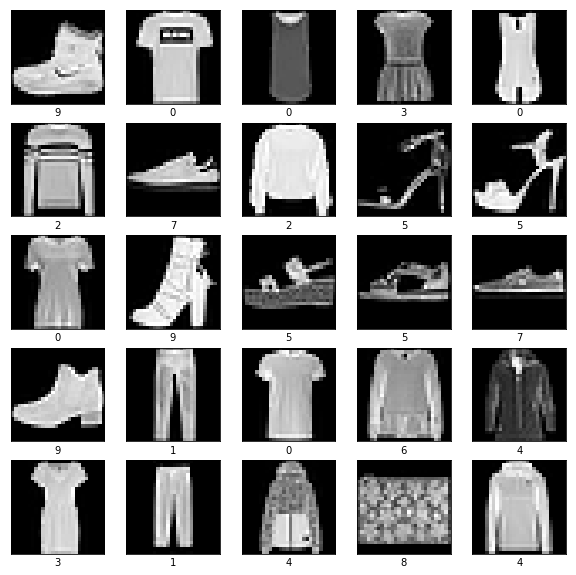

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

***
## Resize
Realizando el resize de las imagenes con las categorias seleccionadas

In [140]:
# Se escogen las tres categorias
categorias = np.array([2,7,9])
# Indices de las categorias seleccionadas
index_train = np.where((train_labels == categorias[0])|(train_labels == categorias[1])|(train_labels == categorias[2]))
index_test = np.where((test_labels == categorias[0])|(test_labels == categorias[1])|(test_labels == categorias[2]))

# Resize de las imagenes de entrenamiento y las de prueba
r_train_images = np.copy(train_images[index_train])
r_test_images = np.copy(test_images[index_test])

train_shape = r_train_images.shape
test_shape = r_test_images.shape

r_train_images.resize((train_shape[0], train_shape[1]*train_shape[2]))
print(r_train_images.shape)
r_test_images.resize((test_shape[0], test_shape[1]*test_shape[2]))
print(r_test_images.shape)

(18000, 784)
(3000, 784)


## Onehot Encoding para las label

In [31]:
# Se realiza onehot encoding a las etiquetas
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labels = np.copy(categorias)
categorias = labelencoder.fit_transform(train_labels[index_train])
train_y = np.eye(len(set(train_labels[index_train])))[categorias]

labels = np.copy(categorias)
categorias = labelencoder.fit_transform(test_labels[index_test])
test_y = np.eye(len(set(test_labels[index_test])))[categorias]

num_test = test_y.shape[0]

print(train_y.shape)
print(test_y.shape)

(18000, 3)
(3000, 3)


***
## Get_mini_batches

In [28]:
from numpy import random

def get_mini_batches(X, y, batch_size):
    random_idxs = random.choice(len(y), len(y), replace=False)
    X_shuffled = X[random_idxs,:]
    y_shuffled = y[random_idxs]
    mini_batches = [(X_shuffled[i:i+batch_size,:], y_shuffled[i:i+batch_size]) for i in range(0, len(y), batch_size)]
    return mini_batches

***
## Construcción del grafo y sesión

In [136]:
def entrenamiento(data_x, data_y, lr, t_epoch, batch_size):
    num_train = data_y.shape[0]
    mini_batch = get_mini_batches(data_x, data_y, batch_size)
    t_batch = int(num_train/batch_size)

    tf.reset_default_graph()
    grafo = tf.Graph()
    with grafo.as_default() as g:
        X = tf.placeholder("float", shape = [None, 784], name = "X_train")
        Y = tf.placeholder("float", shape = [None, 3], name = "Y_train")
        W = tf.Variable(tf.ones([784, 3]), name = "W")
        b = tf.Variable(tf.ones([3]), name = "b")
        
        with tf.name_scope('Mult') as scope:
            mul = tf.add(tf.matmul(X, W), b)
        with tf.name_scope('Softmax') as scope:
            soft = tf.nn.softmax(mul, name = "Softmax")
        with tf.name_scope('Entropia_Cruzada') as scope:
            cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(soft), reduction_indices = 1))
            cost_summary = tf.summary.scalar("cost", cost)
            optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
        with tf.name_scope("init") as scope:
            init = tf.global_variables_initializer()
        
    with tf.Session(graph = grafo) as sess:
        writer = tf.summary.FileWriter('./graphs/lr_prueba_'+str(2), sess.graph)
        sess.run(init)
        for epoch in range(t_epoch):
            optimizacion = sess.run(cost, feed_dict = {X: data_x, Y: data_y})
            print(optimizacion)
            #for b in mini_batch:
                #batch_x = b[0]
                #print(batch_x)
                #batch_y = b[1]
                #print(batch_y)
                #optimizacion = sess.run(cost, feed_dict = {X: batch_x, Y: batch_y})
                #resultado_costo += sess.run(cost, feed_dict = {X: batch_x, Y: batch_y})
                #print(optimizacion)
                
            #resultado_costo /= t_batch
            #print(optimizacion)
            #training_cost, weight, bias = sess.run([cost, W, b], feed_dict = {X: data_x, Y: data_y, learning_rate: lr})
            #if (epoch + 1) % 50 == 0:
            #    c = sess.run(cost_summary, feed_dict = {X : data_x, Y : data_y, learning_rate : lr})
            #    writer.add_summary(c, epoch+1)
            #    print("Epoch", (epoch + 1), ": cost =", training_cost, "W =", weight, "b =", bias)
        #print(optimizacion)
        writer.close()

In [139]:
entrenamiento(r_train_images, train_y, 0.001, 10, 32)

1.0986125
1.0986125
1.0986125
1.0986125
1.0986125
1.0986125
1.0986125
1.0986125
1.0986125
1.0986125


***
## Entrenamiento